This script will attempt to process and plot echosounder and amplitude Data as a means of understanding sediment characteristics.

In [11]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.io import loadmat

In [12]:
deployment_num = 1
sensor_id = "E1_103071"
# directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [13]:
# Import seabird data
sbepath = "Z:\deployment_1\Raw\E1RBR\SBE_00003570_DEP4_FPSE1_L0.mat"
stuff = loadmat(
    sbepath
)  # Load mat oragnizes the 4 different data structures of the .mat file (Units, Config, Data, Description) as a
# dictionary with four nested numpy arrays with dtypes as data field titles
sbe = {}
for names in stuff.keys():
    sbe[names] = stuff[
        names
    ]  # Convert the numpy arrays to a dictionary with the data field titles as keys
    print(names)
del stuff

__header__
__version__
__globals__
SN
time
conductivity
temperature
pressure
salinity
units
notes


In [14]:
# Create dictionary for each sensor
dirpath = os.path.join(
    directory_initial_user_path,
    f"deployment_{deployment_num}/Processed/",
    f"{sensor_id}",
    "Group36",
)  # path to the directory containing the h5 files
files = os.listdir(dirpath)  # list of files for the sensor
Data = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split(".")[0]  # file name
    print(file_name)
    Data[file_name] = df  # store Dataframe
globals()[f"Data_{sensor_id}"] = Data

AbsVel
Time
EastVel
NorthVel
VertVel
ErrVel
Heading
Roll
Pitch
Pressure
VelBeamCorr1
VelBeamCorr2
VelBeamCorr3
VelBeamCorr4
CellDepth
Echo1
Echo2
CellDepth_echo
AmpBeam1
AmpBeam2
AmpBeam3
AmpBeam4
VbAmplitude


In [20]:
filepath = "Z:\deployment_1\BulkStats\E1_103071"
files = os.listdir(filepath)  # list of files for the sensor
waves = {}
for file in files:
    file_path = os.path.join(filepath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split(".")[0]  # file name
    print(file_name)
    waves[file_name] = df # store Dataframe
globals()[f"waves_{sensor_id}"] = waves

GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
VolumetricBackscatter1
VolumetricBackscatter2
Echo1avg
Echo2avg
SedTime
Vertavg
TargetStrength
BottomhalfScatterersavg
TophalfScatterersavg
TopVolumetricBackscatter1
BotVolumetricBackscatter1
Pressure


In [16]:
"""This section will test calculate target strength"""


# Attempts at sediment attentuation of the amplitude data, at the start are the required parameters for calculation
def sediment_analysis(Echo, S, T, P, CellDepth_echo, Burst_Pressure, transmit_length):

    ph = 8.1
    freq = 1000  # kHz
    transmit_power = 0
    beam_angle = 0.015
    Csv = 0
    transmit_length_sec = transmit_length / 1000

    # Convert to arrays
    echo_array = Echo.values
    ranges = CellDepth_echo.values.flatten()  # shape (n_cells,)
    n_samples, n_cells = echo_array.shape

    # build depth matrix
    pressures = Burst_Pressure.values.flatten()  # shape (n_samples,)
    depths_matrix = pressures[:, None] - ranges[None, :]  # shape (n_samples, n_cells)
    depths_matrix[depths_matrix <= 0] = 0

    range_matrix = np.tile(ranges, (n_samples, 1))  # shape (n_samples, n_cells)

    

    T0 = float(np.nanmean(T))
    S0 = float(np.nanmean(S))

    # Sound speed
    soundspeed = (
        1448.96 + 4.591 * T0 - 5.304e-2 * T0**2 + 2.374e-4 * T0**3 + 1.34 * (S0 - 35)
    )

    # Attenuation coefficients
    A_1 = (8.66 * 10 ** (0.78 * ph - 5)) / soundspeed
    A_2 = (21.44 * S0 * (1 + 0.025 * T0)) / soundspeed
    f_1 = 2.8 * np.sqrt(S0 / 35) * 10 ** (4 - 1245 / (T0 + 273))
    f_2 = (8.17 * 10 ** (8 - (1990 / (T0 + 273)))) / (1 + 0.0018 * (S0 - 35))

    P_2 = 1 - 1.37e-4 * depths_matrix + 6.2e-9 * depths_matrix**2
    P_3 = 1 - 3.83e-5 * depths_matrix + 4.9e-10 * depths_matrix**2

    if T0 <= 20:
        A_3 = 4.937e-4 - 2.59e-5 * T0 + 3.2e-7 * T0**2 - 1.5e-8 * T0**3
    else:
        A_3 = 3.964e-4 - 1.146e-5 * T0 + 1.45e-7 * T0**2 - 6.5e-10 * T0**3

    # absorption, shape: (n_samples, n_cells)
    a_w = (freq**2) * (
        ((A_1 * f_1) / (f_1**2 + freq**2))
        + ((A_2 * P_2 * f_2) / (f_2**2 + freq**2))
        + A_3 * P_3
    )
    a_w /= 1000  # dB/m

    # Sv calculation
    Sv = (
        echo_array * 0.43
        + 20 * np.log10(range_matrix)
        + 2 * a_w * range_matrix
        + transmit_power
        - 10 * np.log10((soundspeed * transmit_length_sec) / 2)
        - beam_angle
        + Csv
    )

    print("Look at magnitudes",20 * np.log10(range_matrix).max(),a_w.max(),np.nanmax(echo_array*.43))

    # TS calculation
    TS = (
        echo_array * 0.43
        + 40 * np.log10(10 * range_matrix)
        + 2 * a_w * range_matrix
        + transmit_power
    )

    # Convert back to DataFrames
    Sv_df = pd.DataFrame(Sv, index=Echo.index, columns=Echo.columns)
    TS_df = pd.DataFrame(TS, index=Echo.index, columns=Echo.columns)

    # mean echo amplitude
    echoavg = Echo.mean(axis=1)

    return echoavg, Sv_df, TS_df, depths_matrix


Echo1avg, S_v1, TS, depths_matrix = sediment_analysis(
    Data["Echo1"],
    sbe["salinity"],
    sbe["temperature"],
    sbe["pressure"],
    Data["CellDepth_echo"],
    Data["Pressure"],
    0.330,
)

Echo2avg, S_v2, ___, ___ = sediment_analysis(
    Data["Echo2"],
    sbe["salinity"],
    sbe["temperature"],
    sbe["pressure"],
    Data["CellDepth_echo"],
    Data["Pressure"],
    0.033,
)


Look at magnitudes 23.722167725693946 0.32593752906287954 35.518
Look at magnitudes 23.722167725693946 0.32593752906287954 49.5919


In [17]:
# """This section will generate plots to look at echosounder backscatter and target strength"""

# fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# # Plot 1: Echo1
# pcm0 = axs[0].pcolormesh(
#     Data["Time"][0],
#     Data["CellDepth_echo"],
#     Data["Echo1"].T,
#     shading="auto",
#     cmap="viridis",
# )
# axs[0].set_title("Echo Intensity Channel 1")
# axs[0].set_ylabel("Range (m)")
# cbar0 = fig.colorbar(pcm0, ax=axs[0], orientation="vertical")
# cbar0.set_label("Intensity (dB)")

# # Plot 2: S_v1
# pcm1 = axs[1].pcolormesh(
#     Data["Time"][0], Data["CellDepth_echo"], S_v1.T, shading="auto"
# )
# axs[1].set_title("Volume Backscattering (Sv1)")
# axs[1].set_ylabel("Range (m)")
# cbar1 = fig.colorbar(pcm1, ax=axs[1], orientation="vertical")
# cbar1.set_label("Sv (dB)")

# # Plot 3: TS
# pcm2 = axs[2].pcolormesh(
#     Data["Time"][0], Data["CellDepth_echo"], TS.T, shading="auto"
# )
# axs[2].set_title("Target Strength (TS)")
# axs[2].set_ylabel("Range (m)")
# cbar2 = fig.colorbar(pcm2, ax=axs[2], orientation="vertical")
# cbar2.set_label("TS (dB)")

# # Plot 4: Optional – leave blank or add another variable
# pcm3 = axs[3].pcolormesh(
#     Data["Time"][0], Data["CellDepth_echo"], (S_v1 - np.nanmean(S_v1,axis = 0)).T, shading="auto"
# )
# axs[3].set_title("Volumetric Backscatter with mean over time removed")
# axs[3].set_ylabel("Range (m)")
# cbar3 = fig.colorbar(pcm3, ax=axs[3], orientation="vertical")
# cbar3.set_label("Sv (dB)")



# for ax in axs:
#     ax.set_ylim(6,10)
#     ax.set_xlim(datetime.datetime(2024,9,15,20,00),datetime.datetime(2024,9,15,20,5))
# # General layout tweaks
# plt.tight_layout()
# fig.autofmt_xdate(rotation=30)

# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\E1_closelookatwaves_.png")

In [18]:
print(waves_E1_103071.keys())

dict_keys([])


C:\Users\lwlav\AppData\Local\Temp\ipykernel_20848\797184066.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\lwlav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\lwlav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


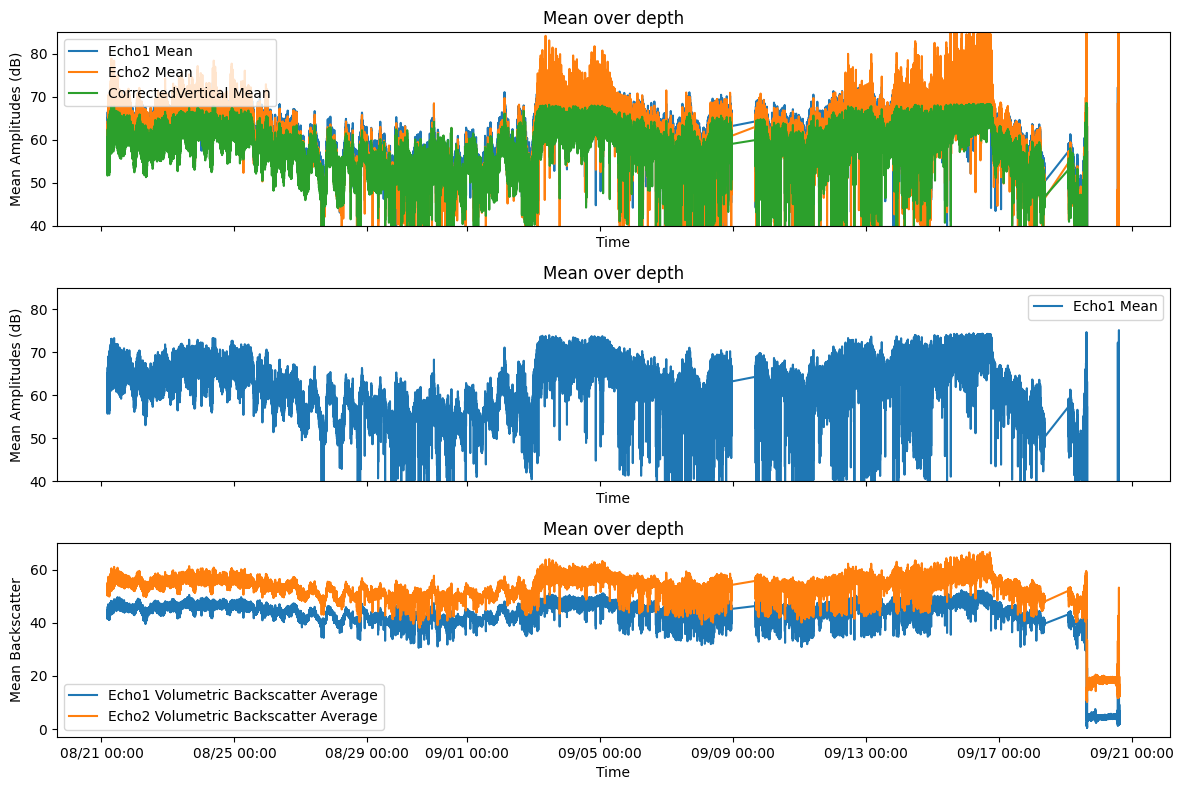

In [21]:
# Integrated and avg backscatter over depth bins (you have to avg the echosounder to same bin size as vertbeam first)


fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1 Mean")
axs[0].plot(waves["SedTime"], waves["Echo2avg"], label="Echo2 Mean")
axs[0].plot(waves["SedTime"], waves["Vertavg"] - 17, label="CorrectedVertical Mean")
axs[0].set_title("Mean over depth")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(40, 85)
axs[0].legend()

axs[1].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1 Mean")
axs[1].set_title("Mean over depth")
axs[1].set_ylabel("Mean Amplitudes (dB)")
axs[1].set_xlabel("Time")
axs[1].set_ylim(40, 85)
axs[1].legend()

axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter1"],
    label="Echo1 Volumetric Backscatter Average",
)
axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter2"],
    label="Echo2 Volumetric Backscatter Average",
)
axs[2].set_title("Mean over depth")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend()




for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_backscatter_.png")

**This section will look at the two different scatterer halfs**

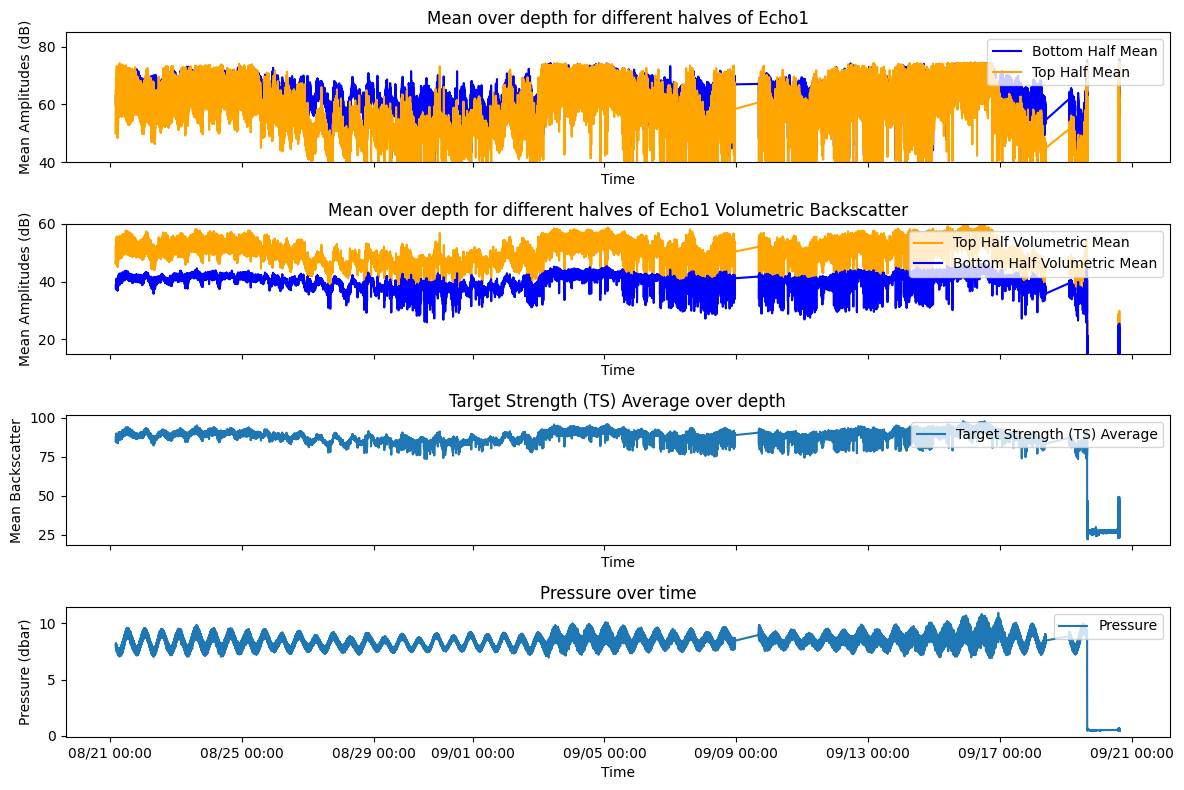

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(waves["SedTime"], waves["BottomhalfScatterersavg"], label="Bottom Half Mean", color='blue')
axs[0].plot(waves["SedTime"], waves["TophalfScatterersavg"], label="Top Half Mean", color ='orange')
axs[0].set_title("Mean over depth for different halves of Echo1")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(40, 85)
axs[0].legend(loc = 'upper right')

axs[1].plot(waves["SedTime"], waves["TopVolumetricBackscatter1"], label="Top Half Volumetric Mean",color ='orange')
axs[1].plot(waves["SedTime"], waves["BotVolumetricBackscatter1"], label="Bottom Half Volumetric Mean", color='blue')
axs[1].set_title("Mean over depth for different halves of Echo1 Volumetric Backscatter")
axs[1].set_ylabel("Mean Amplitudes (dB)")
axs[1].set_xlabel("Time")
axs[1].set_ylim(15, 60)
axs[1].legend(loc = 'upper right')

axs[2].plot(
    waves["SedTime"],
    waves["TargetStrength"],
    label="Target Strength (TS) Average",
)
axs[2].set_title("Target Strength (TS) Average over depth")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend(loc = 'upper right')

axs[3].plot(
    waves["SedTime"],
    waves["Pressure"],
    label="Pressure"
)
axs[3].set_title("Pressure over time")
axs[3].set_ylabel("Pressure (dbar)")
axs[3].set_xlabel("Time")
axs[3].legend(loc = 'upper right')


for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.tight_layout()
plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_halvsies_.png")

**This section will look at major events and as well as calm periods in the signals**

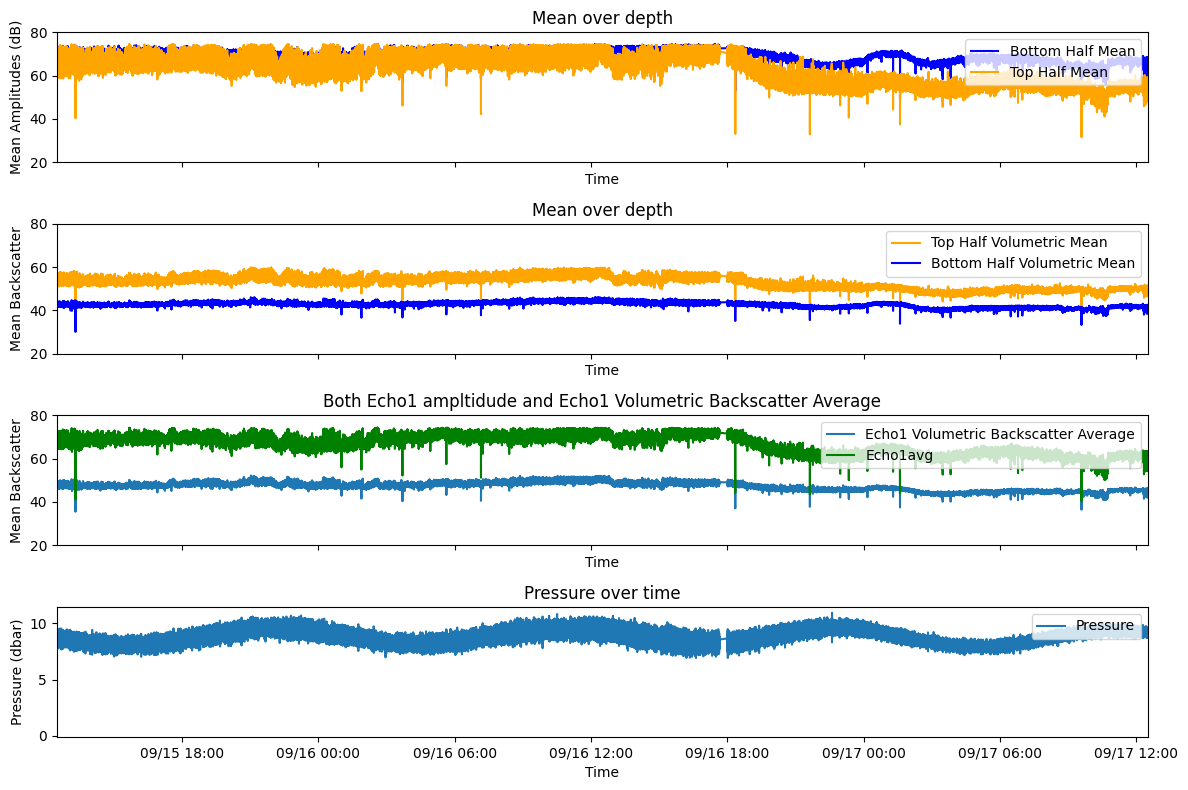

In [27]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(waves["SedTime"], waves["BottomhalfScatterersavg"], label="Bottom Half Mean", color='blue')
axs[0].plot(waves["SedTime"], waves["TophalfScatterersavg"], label="Top Half Mean", color ='orange')
axs[0].set_title("Mean over depth")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(20, 80)
axs[0].legend(loc = 'upper right')

axs[1].plot(waves["SedTime"], waves["TopVolumetricBackscatter1"], label="Top Half Volumetric Mean", color ='orange')
axs[1].plot(waves["SedTime"], waves["BotVolumetricBackscatter1"], label="Bottom Half Volumetric Mean", color='blue')
axs[1].set_title("Mean over depth")
axs[1].set_ylabel("Mean Backscatter")
axs[1].set_xlabel("Time")
axs[1].set_ylim(20, 80)
axs[1].legend(loc = 'upper right')

axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter1"],
    label="Echo1 Volumetric Backscatter Average"
)
axs[2].plot(
    waves["SedTime"],
    waves["Echo1avg"],
    label= 'Echo1avg', color = 'green'
)
axs[2].set_title("Both Echo1 ampltidude and Echo1 Volumetric Backscatter Average")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend(loc = 'upper right')
axs[2].set_ylim(20, 80)

axs[3].plot(
    waves["SedTime"],
    waves["Pressure"],
    label="Pressure"
)
axs[3].set_title("Pressure over time")
axs[3].set_ylabel("Pressure (dbar)")
axs[3].set_xlabel("Time")
axs[3].legend(loc = 'upper right')



for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    ax.set_xlim(datetime.datetime(2024,9,15,12,30),datetime.datetime(2024,9,17,12,30))
plt.tight_layout()
plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_TC8_.png")

***This section will perform some analyses on Vertical Beam and Echosounder***

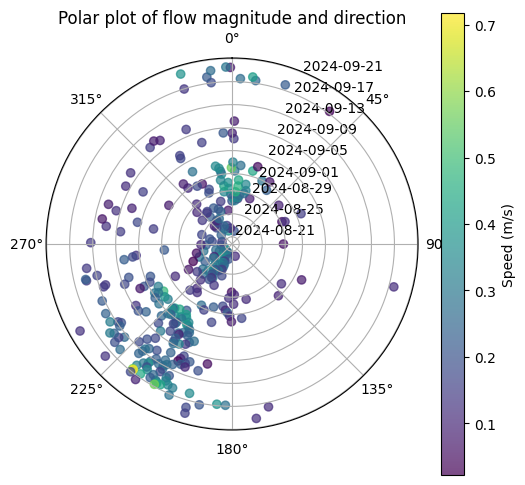

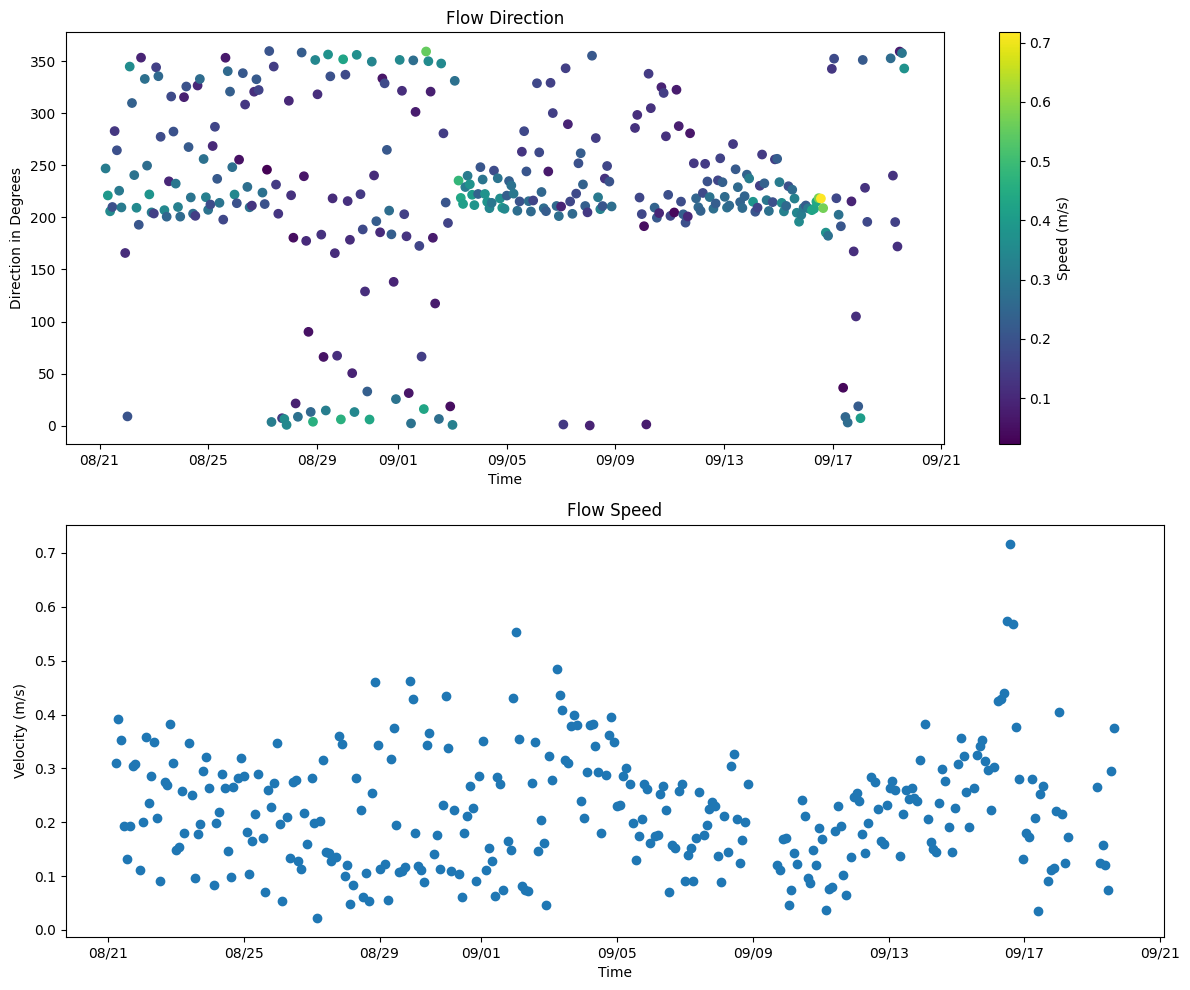

In [26]:
# Orbital plot to look at flow direction


# Convert to radians
speed = waves["DepthAveragedCurrentVelocity"]

dir_rad = np.deg2rad(waves["DepthAveragedFlowDirection"])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
sc = ax.scatter(dir_rad, waves["Time"].values, c=speed, cmap="viridis", alpha=0.7)

ax.set_theta_zero_location("N")  # set 0° at north
ax.set_theta_direction(-1)  # clockwise
plt.title("Polar plot of flow magnitude and direction")
plt.colorbar(sc, label="Speed (m/s)")
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_polarflowdir.png")

figs, axs = plt.subplots(2, 1, figsize=(12, 10))
gg = axs[0].scatter(waves["Time"].values, waves["DepthAveragedFlowDirection"], c=speed)
plt.colorbar(gg, label="Speed (m/s)")
axs[0].set_title("Flow Direction")
axs[0].set_ylabel("Direction in Degrees")
axs[0].set_xlabel("Time")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.tight_layout()

gg1 = axs[1].scatter(waves["Time"].values, waves["DepthAveragedCurrentVelocity"])
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time")
axs[1].set_title("Flow Speed")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_flowdir.png")

**This section will look at the spectra from the deployment**